## Modules

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib

%matplotlib inline

## Samples
### Assignments of amounts

In [2]:
img_lao = []
img_rao = []
num_lao = 20
num_rao = 20

num_train = 14
num_test = 6

## Image Input

In [3]:
for i in range(num_lao):
    if i <10:
        filename = 'CAG/p000'+str(i)+'l.bmp'
    elif i>=10 and i<100:
        filename = 'CAG/p00'+str(i)+'l.bmp'
        
    img = Image.open(filename)
    img_lao.append(img)
    
for i in range(num_rao):
    if i <10:
        filename = 'CAG/p000'+str(i)+'r.bmp'
    elif i>=10 and i<100:
        filename = 'CAG/p00'+str(i)+'r.bmp'
    img = Image.open(filename)
    img_rao.append(img)

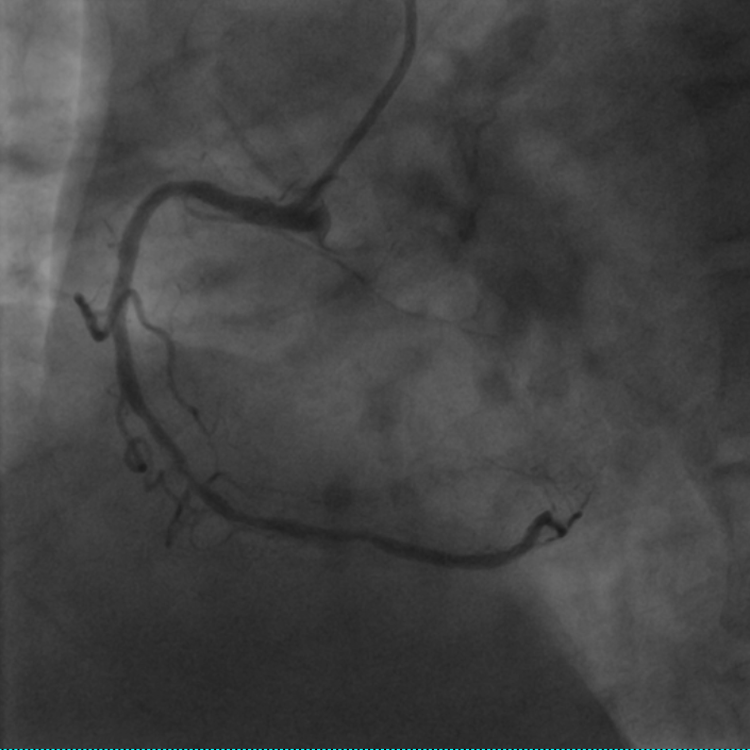

In [4]:
img_rao[19]

## Functions

In [5]:
def extractData(image):
    x = image.size[0]
    y = image.size[1]
    
    matrix = []
    rgb_matrix = []

    for i in range(x):
        matrix.append([])
        rgb_matrix.append([])
        
        for j in range(y):
            r, g, b = image.getpixel((j, i))            
            value = r * 299.0/1000 + g * 587.0/1000 + b * 114.0/1000
            value = int(value)
            matrix[i].append(value)
            rgb_matrix[i].append((r,g,b))
    return matrix, rgb_matrix

In [6]:
def limitedEqualize(image, limit=4.0):
    
    image_limited_equalized_list = []
    
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(8,8))  #CLAHE (Contrast Limited Adaptive Histogram Equalization)
    image_limited_equalized_list = clahe.apply(image)

    image_limited_equalized = np.array(image_limited_equalized_list, dtype=np.uint8)
    return image_limited_equalized

In [7]:
def imageReconstruct(matrix):
    df = np.array(matrix, dtype=np.uint8)
    img = Image.fromarray(df, 'RGB')
    img.save('image.png')
    return img

## Data Extraction from Images

In [8]:
data_rao = []
data_lao = []

rgb_data_rao = []
rgb_data_lao = []

for case_rao in img_rao:
    grey, rgb = extractData(case_rao)
    data_rao.append(grey)
    rgb_data_rao.append(rgb)
    
for case_lao in img_lao:
    grey, rgb = extractData(case_lao)
    data_lao.append(grey)
    rgb_data_lao.append(rgb)

In [9]:
imageMatrix = np.array(rgb_data_rao[0])

### * bug existed

In [10]:
# img_limited_equalized = limitedEqualize(imageMatrix, 4.0)

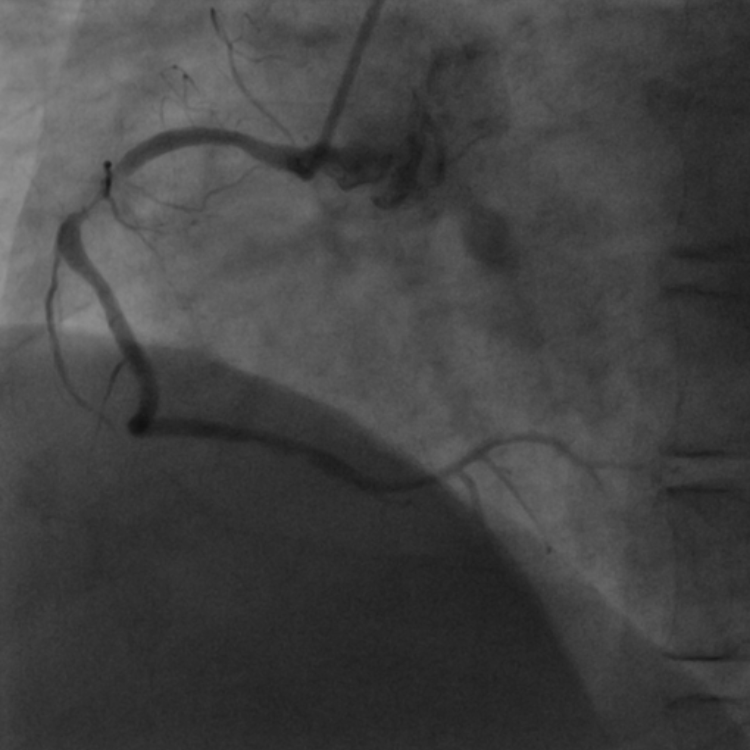

In [11]:
img = imageReconstruct(imageMatrix)
img

## Flat Transformation from 2D to 1D

In [12]:
data_rao_flat = []
data_lao_flat = []

for case_rao in data_rao:    
    #data_case = extractData(case_rao)
    case_flat = []
    for row in case_rao:
        for column in row:
            case_flat.append(column)            
    data_rao_flat.append(case_flat)
    
for case_lao in data_lao:    
    #data_case = extractData(case_lao)
    case_flat = []
    for row in case_lao:
        for column in row:
            case_flat.append(column)
    data_lao_flat.append(case_flat)

## Support Vector Classification

In [13]:
c = [1] * num_train + [2] * num_train

c

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

### Training

In [14]:
X_train = np.array(data_lao_flat[:num_train] + data_rao_flat[:num_train])
y_train = np.array(c)

clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Prediction

In [15]:
print('w = ',clf.coef_)
print('b = ',clf.intercept_)
print('Indices of support vectors = ', clf.support_)
print('Support vectors = ', clf.support_vectors_)
print('Number of support vectors for each class = ', clf.n_support_)
print('Coefficients of the support vector in the decision function = ', np.abs(clf.dual_coef_))

w =  [[ 4.31810575e-07  4.35823719e-07  4.41510651e-07 ... -9.32025043e-08
  -6.98251524e-08  2.22317952e-07]]
b =  [0.64045905]
Indices of support vectors =  [ 3  5  7 11 12 15 16 17 25]
Support vectors =  [[ 87.  86.  86. ... 114. 113. 113.]
 [ 80.  82.  82. ... 102. 101.  98.]
 [ 44.  42.  41. ... 127. 127. 127.]
 ...
 [107. 107. 107. ...  48.  45.  42.]
 [145. 145. 145. ... 192. 192. 192.]
 [107. 105. 104. ...  70.  69.  74.]]
Number of support vectors for each class =  [5 4]
Coefficients of the support vector in the decision function =  [[7.26872741e-10 1.00027615e-09 1.24068909e-09 3.73501650e-09
  1.20702310e-10 1.16740572e-09 9.88023954e-10 4.08263972e-09
  5.85487397e-10]]


In [16]:
clf.predict(data_lao_flat[-num_test:] + data_rao_flat[-num_test:])

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

## Performance Measures

In [17]:
y_predict = clf.predict(data_lao_flat[-num_test:] + data_rao_flat[-num_test:])

In [18]:
y_test = [1] * num_test + [2] * num_test

In [19]:
y_predict

array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])

### Confusion Matrix (混淆矩阵)

In [20]:
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,2]))
confusion = pd.DataFrame(cm, index=['LCA', 'RCA'],
                        columns=['Predictive LCA,', 'Predictive RCA'])
confusion

,"Predictive LCA,",Predictive RCA
LCA,6,0
RCA,0,6


In [21]:
print(classification_report(y_test, y_predict))

             precision    recall  f1-score   support

          1       1.00      1.00      1.00         6
          2       1.00      1.00      1.00         6

avg / total       1.00      1.00      1.00        12



## Save the Model

In [22]:
c = joblib.dump(clf, 'trained_model.m')
print(c)

['trained_model.m']


## Load the Model

In [23]:
d = joblib.load('trained_model.m')
print(d)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [24]:
img_weird = []
filenames = ['CAG/p0088l.bmp', 'CAG/p0088r.bmp', 'CAG/p0066l.bmp']
for filename in filenames:
    img = Image.open(filename)
    img_weird.append(img)
    
data_weird = []
rgb_data_weird = []

for case_weird in img_weird:
    grey, rgb = extractData(case_weird)
    data_weird.append(grey)
    rgb_data_weird.append(rgb)
    
data_weird_flat = []

for case_weird in data_weird:    
    #data_case = extractData(case_rao)
    case_flat = []
    for row in case_weird:
        for column in row:
            case_flat.append(column)            
    data_weird_flat.append(case_flat)


In [25]:
d.predict(data_weird_flat)

array([1, 2, 1])

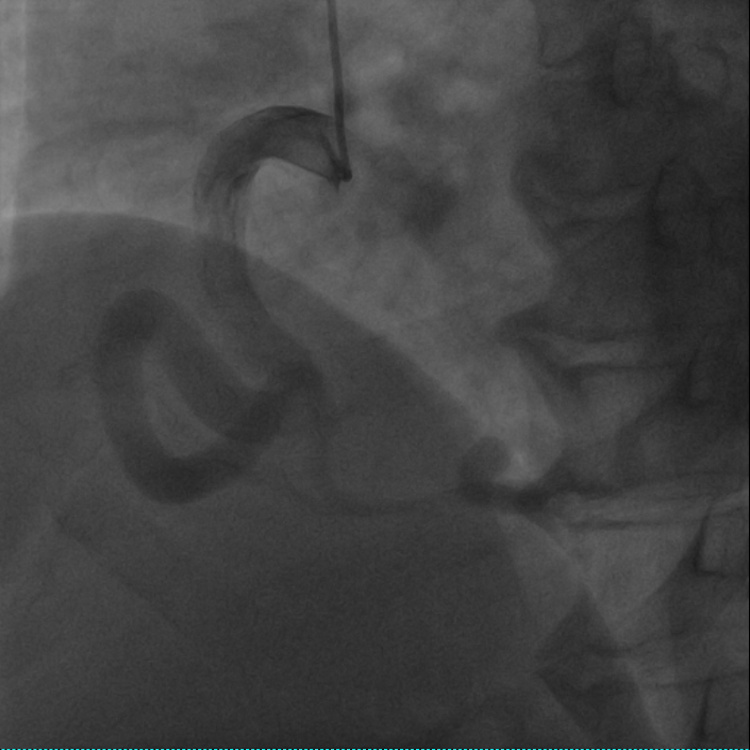

In [26]:
img = imageReconstruct(np.array(rgb_data_weird[1]))
img